C:\Users\Eric\AppData\Roaming\Python\Python312\site-packages\statsforecast\core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Missing values:
Day        0
Revenue    0
dtype: int64


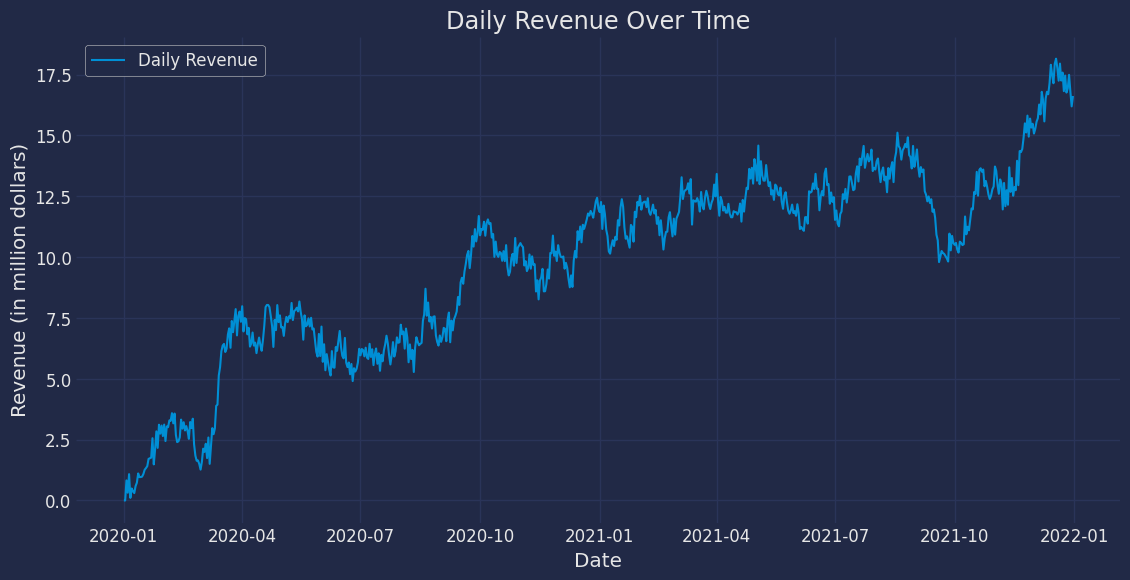

In [1]:
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima
from pylab import rcParams
from scipy.signal import periodogram
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

plt.style.use("fivethirtyeight")
plt.rcParams["lines.linewidth"] = 1.5
dark_style = {
    "figure.facecolor": "#212946",
    "axes.facecolor": "#212946",
    "savefig.facecolor": "#212946",
    "axes.grid": True,
    "axes.grid.which": "both",
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "grid.color": "#2A3459",
    "grid.linewidth": "1",
    "text.color": "0.9",
    "axes.labelcolor": "0.9",
    "xtick.color": "0.9",
    "ytick.color": "0.9",
    "font.size": 12,
}
plt.rcParams.update(dark_style)

rcParams["figure.figsize"] = (18, 7)


# Load the dataset without index column
df = pd.read_csv("teleco_time_series.csv", index_col=False)

start_date = pd.to_datetime("2020-01-01")
df["Day"] = start_date + pd.to_timedelta(df["Day"] - 1, unit="D")

missing_values = df.isnull().sum()
print(f"Missing values:\n{missing_values}")

df.columns = ["date", "revenue"]
df.set_index("date", inplace=True)
df_diff = df.diff().dropna()

# DATA CLEANING
# C1.  Summarize the data cleaning process by doing the following: Provide a line graph visualizing the realization of the time series.

# Plot the time series df
plt.figure(figsize=(12, 6))
plt.plot(df.index, df.revenue, label="Daily Revenue")
plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue (in million dollars)")
plt.legend()
plt.show()

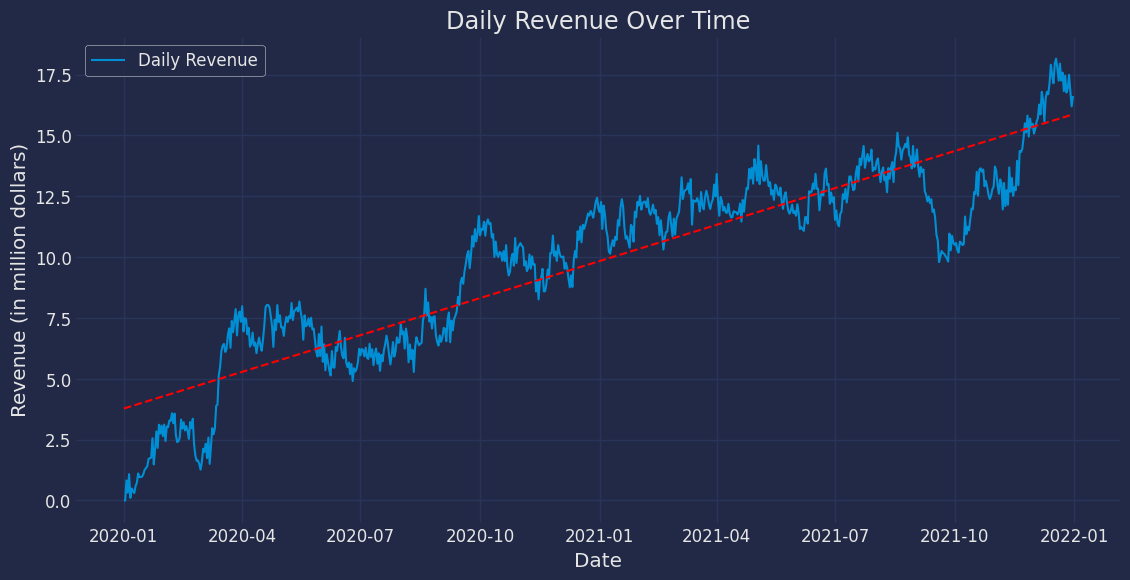

In [2]:
# C3.  Evaluate the stationarity of the time series.
# Plot the data with a trend line to evaluate stationarity

plt.figure(figsize=(12, 6))
plt.plot(df.index, df.revenue, label="Daily Revenue")
plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue (in million dollars)")
plt.legend()
# Add trend line
x = matplotlib.dates.date2num(df.index)
y = df.revenue
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

In [3]:
# SPLIT TO TRAINING AND TEST
# C4.  Explain the steps you used to prepare the data for analysis, including the training and test set split.

# Split the df into training and testing sets
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

# C5.  Provide a copy of the cleaned data set.
df.to_csv("teleco_cleaned.csv")
train_data.to_csv("train.csv")
test_data.to_csv("test.csv")

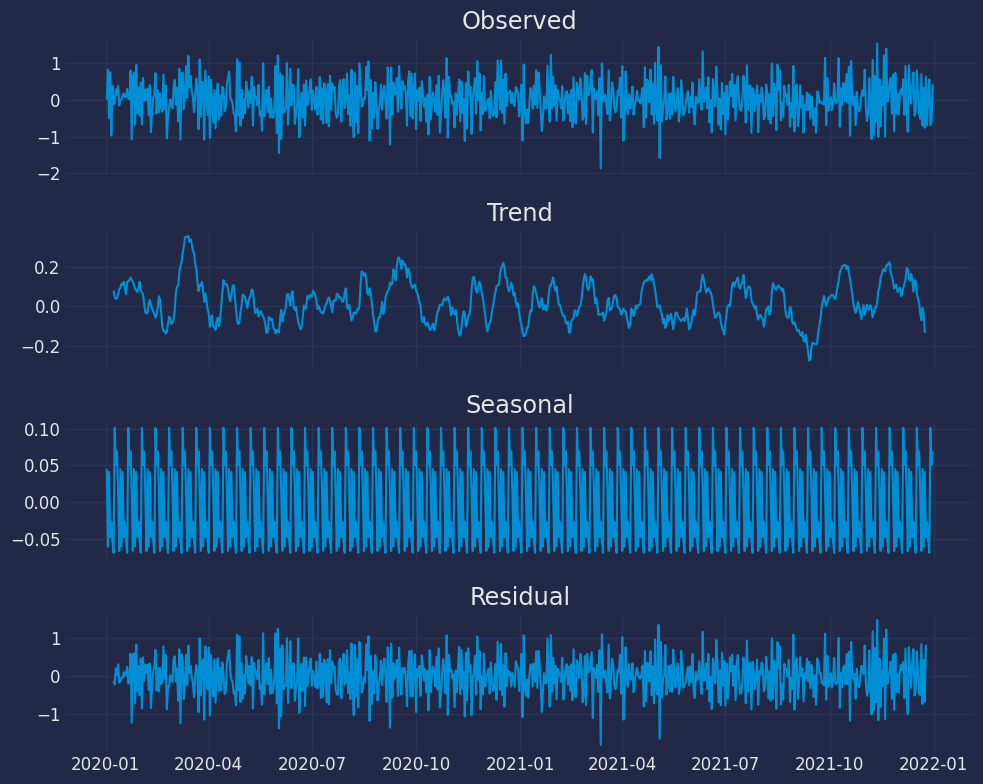

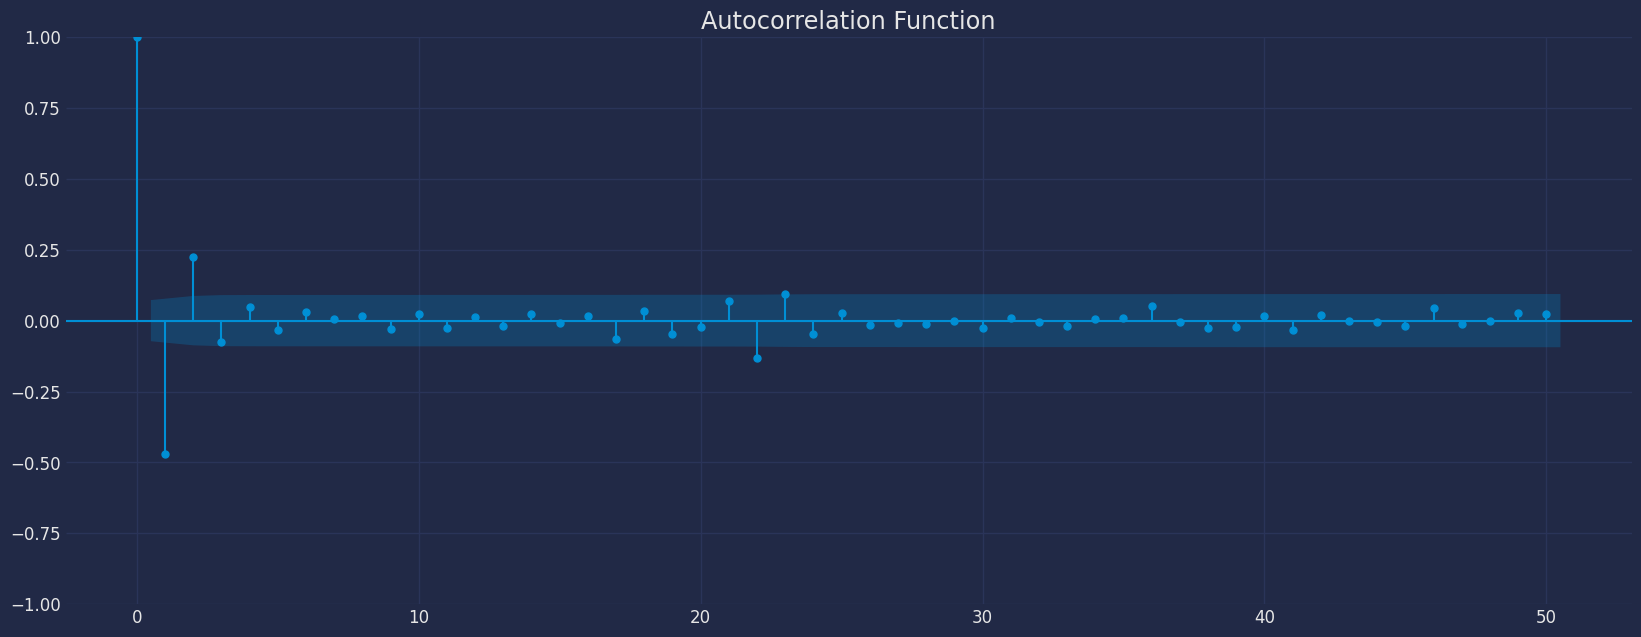

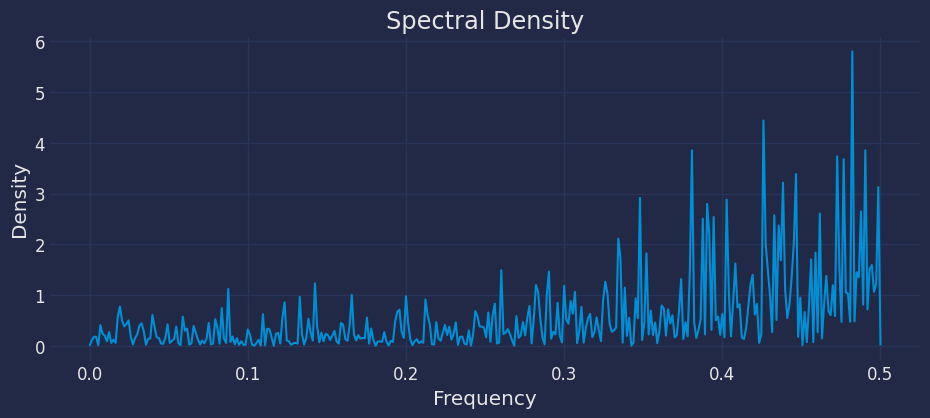

In [4]:
# D1. Analyze the time series data set by doing the following: Report the annotated findings with visualizations of your data analysis, including the following elements: the presence or lack of a seasonal component, trends, the autocorrelation function, the spectral density, the decomposed time series, confirmation of the lack of trends in the residuals of the decomposed series

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import periodogram

# Assuming df_diff is your DataFrame with a datetime index and a 'value_diff' column

# Decompose the time series
decomposition = seasonal_decompose(
    df_diff.revenue, model="additive", period=12
)  # Adjust 'period' as necessary

# Plotting the decomposed components
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Observed
axs[0].plot(decomposition.observed)
axs[0].set_title("Observed")
# Trend
axs[1].plot(decomposition.trend)
axs[1].set_title("Trend")
# Seasonal
axs[2].plot(decomposition.seasonal)
axs[2].set_title("Seasonal")
# Residual
axs[3].plot(decomposition.resid)
axs[3].set_title("Residual")

plt.tight_layout()
plt.show()

# Autocorrelation Function (ACF)
plot_acf(df_diff.revenue, lags=50)
plt.title("Autocorrelation Function")
plt.show()

# Spectral Density
frequencies, spectrum = periodogram(df_diff.revenue)
plt.figure(figsize=(10, 4))
plt.plot(frequencies, spectrum)
plt.title("Spectral Density")
plt.xlabel("Frequency")
plt.ylabel("Density")
plt.show()

In [5]:
model = auto_arima(
    train_data,
    start_p=0,
    d=1,
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=5,
    max_D=5,
    max_Q=5,
    m=12,
    seasonal=True,
    error_action="warn",
    trace=True,
    supress_warnings=True,
    stepwise=True,
    random_state=493,
    n_fits=50,
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1476.624, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1138.788, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1335.231, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1031.401, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1000.471, Time=0.92 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=990.859, Time=1.66 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=975.733, Time=3.14 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=11.43 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=11.82 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1134.402, Time=2.56 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=977.448, Time=3.40 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=977.515, Time=3.57 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=1011.645, Time=2.29 sec
 ARIMA(2,1,1)(5,1,0)[12]            

In [6]:
# D3.  Perform a forecast using the derived ARIMA model identified in part D2.
model = ARIMA(df.revenue, order=(1, 1, 0), seasonal_order=(5, 1, 0, 12))

results = model.fit()

prediction = pd.DataFrame(results.predict(n_periods=12), index=test_data.index)
prediction.columns = ["revenue"]
print(prediction)

C:\Users\Eric\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Eric\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Eric\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


              revenue
date                 
2021-11-02  13.779718
2021-11-03  13.447428
2021-11-04  13.219613
2021-11-05  12.576843
2021-11-06  12.796155
2021-11-07  12.961770
2021-11-08  12.284620
2021-11-09  12.400134
2021-11-10  12.803153
2021-11-11  12.542590
2021-11-12  12.322439
2021-11-13  13.172537
2021-11-14  13.628074
2021-11-15  12.634529
2021-11-16  12.737806
2021-11-17  12.589010
2021-11-18  12.732351
2021-11-19  13.194090
2021-11-20  13.402889
2021-11-21  13.645821
2021-11-22  14.497677
2021-11-23  14.581788
2021-11-24  14.729128
2021-11-25  15.348861
2021-11-26  15.793060
2021-11-27  15.190317
2021-11-28  15.159284
2021-11-29  15.160185
2021-11-30  15.518367
2021-12-01  15.218484
2021-12-02  15.439015
2021-12-03  15.204798
2021-12-04  15.562540
2021-12-05  15.894843
2021-12-06  16.238140
2021-12-07  16.282032
2021-12-08  16.916875
2021-12-09  16.240975
2021-12-10  15.931651
2021-12-11  16.064576
2021-12-12  16.859911
2021-12-13  16.429610
2021-12-14  17.124206
2021-12-15

In [7]:
# E1.  Summarize your findings and assumptions by doing the following: Discuss the results of your data analysis, including the following points: the selection of an ARIMA model, the prediction interval of the forecast, a justification of the forecast length, the model evaluation procedure and error metric.

rmse = mean_squared_error(test_data, prediction, squared=False)
print("RMSE:", rmse)

RMSE: 0.5895627265365689


C:\Users\Eric\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


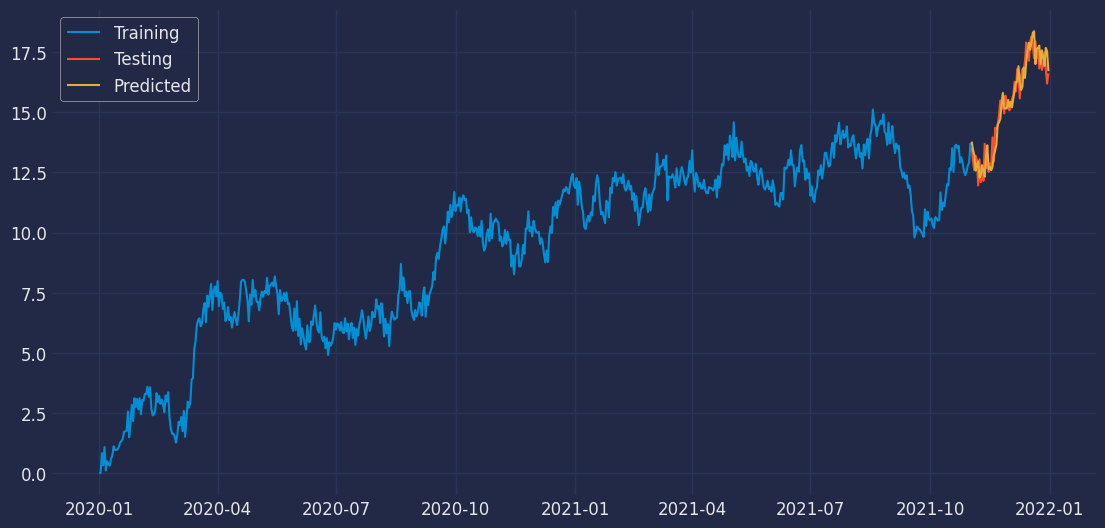

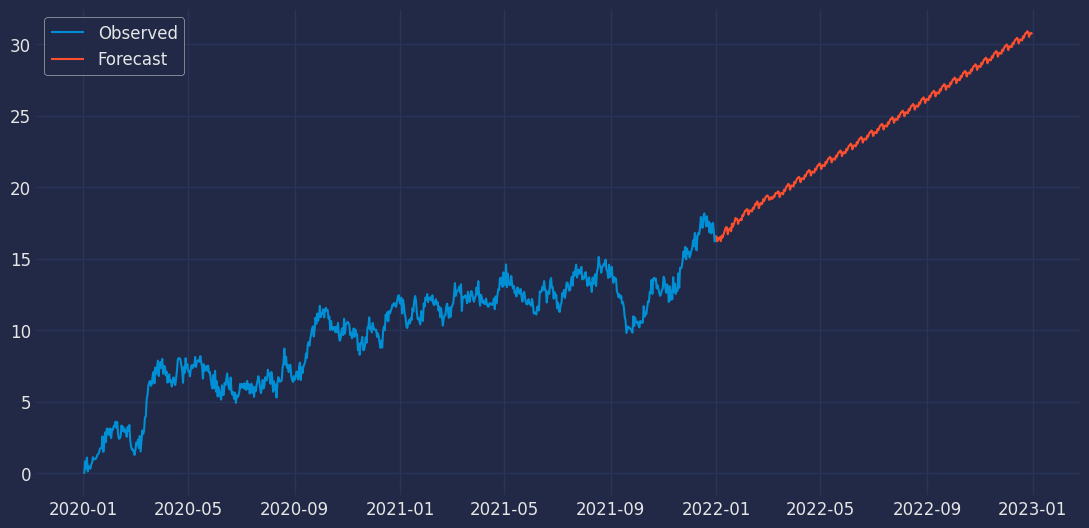

In [8]:
# E2.  Provide an annotated visualization of the forecast of the final model compared to the test set.

plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Training")
plt.plot(test_data, label="Testing")
plt.plot(prediction, label="Predicted")
plt.legend(loc="upper left")
plt.show()

prediction = results.get_prediction(start=len(df), end=len(df) + 365)
plt.figure(figsize=(12, 6))
plt.plot(df, label="Observed")
plt.plot(prediction.predicted_mean, label="Forecast")
plt.legend(loc="upper left")
plt.show()